Si van a realizar el TP con canto Mongol, que sea bien arriba!

https://open.spotify.com/track/4JvM2JzkfRjMYy9pexVeRV?si=6N0bTnkHQOGm-GRvMv7n1A

Import's

In [1]:
from io import BytesIO

import os
import sys
import pickle
import math
import random
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import librosa
import glob

import scipy.io.wavfile

from shutil import copyfile

from IPython.display import Audio

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Notación Científica a Decimal
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Features

In [ ]:
# Desde nuestro repo!
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features = pickle.load(file_)

df_features.shape

(23666, 81)

In [ ]:
df_features.head(3)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013,82.107,30.129,37.495,26.410,19.350,0.221,13.787,-2.091,10.187,-7.550,10.406,0.020,105.243,66.167,31.379,17.045,16.423,8.988,9.500,9.900,9.094,6.358,9.571,5.839,0.020,2.496,2.679,1.383,0.637,0.353,-0.075,-0.396,0.066,0.210,0.001,-0.285,-0.135,0.000,30.678,...,16.547,10.995,9.366,8.321,6.260,6.316,6.087,5.225,6.299,4.700,0.005,-0.892,-0.599,-0.008,0.031,0.060,0.012,-0.036,-0.154,0.044,0.055,-0.319,-0.205,0.000,27.638,17.219,17.457,12.668,12.201,9.885,6.972,6.423,8.006,6.841,7.951,6.087,0.004,zero,zero/b087aa0e_nohash_3.wav,train
1,-467.465,106.486,-15.164,-15.917,-14.514,-0.944,-22.115,-2.099,-15.078,-5.340,-2.508,-4.010,0.014,143.691,70.236,41.396,40.315,12.078,11.623,22.693,9.660,21.297,13.317,17.372,9.551,0.016,-7.602,0.237,0.089,-2.493,-0.741,-1.250,-0.836,-0.696,0.170,0.122,0.354,-0.369,-0.000,39.752,...,20.763,13.505,7.302,7.357,9.344,5.286,8.008,7.524,8.351,6.591,0.004,1.047,0.668,0.701,0.556,0.056,0.025,-0.053,0.377,0.467,-0.151,-0.275,-0.094,0.000,26.817,19.741,18.224,13.531,8.567,8.785,10.018,5.970,7.915,9.536,8.486,7.919,0.002,zero,zero/1a892463_nohash_1.wav,train
2,-387.342,103.399,19.127,14.151,4.236,2.917,-8.341,-4.872,0.061,-0.831,-3.717,2.288,0.012,64.781,35.180,33.912,21.784,12.908,6.430,16.484,13.219,10.295,8.538,6.550,5.132,0.008,-0.206,0.652,-0.220,0.448,-0.305,-0.063,-0.035,-0.006,-0.274,-0.224,-0.302,-0.081,-0.000,22.896,...,13.690,14.482,9.327,5.372,8.143,6.306,7.962,4.619,3.983,4.335,0.002,-0.037,-0.071,0.117,-0.118,-0.021,0.003,-0.007,0.066,0.037,0.016,-0.083,-0.235,0.000,21.680,12.490,10.517,13.018,10.620,6.833,9.695,7.443,8.834,4.592,4.575,5.141,0.002,zero,zero/fb2f3242_nohash_0.wav,train


In [ ]:
# Algunos controles para yo entender la data nuevamente
df_features.groupby('target').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,group
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eight,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352
five,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357
four,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372
nine,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364
one,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370
seven,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377
six,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369
three,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,235

In [ ]:
df_features.groupby('group').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
testing,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552
train,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620
validation,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494


# Modelos

In [ ]:
df_train = df_features[df_features['group'] == 'train']

del df_train['group']
del df_train['file']
len(df_train.index)

18620

In [ ]:
features = df_train.loc[:, df_train.columns != 'target'].columns
target = 'target'

x_train, y_train = df_train[features].values, df_train[target].values

In [ ]:
# Validation Set
df_validation = df_features[df_features['group'] == 'validation']

del df_validation['group']
del df_validation['file']
len(df_validation.index)

2494

In [ ]:
x_validation, y_validation = df_validation[features].values, df_validation[target].values

In [ ]:
# Test Set
df_test = df_features[df_features['group'] == 'testing']

del df_test['group']
del df_test['file']
len(df_test.index)

2552

In [ ]:
x_test, y_test = df_test[features].values, df_test[target].values

### Bagging Parameters


*   n_estimators
*   max_features
*   oob_score

### Tree-specific Parameters


*   max_depth
*   min_samples_split
*   min_samples_leaf
*   class_weight (balanced)



### Naive Bayes

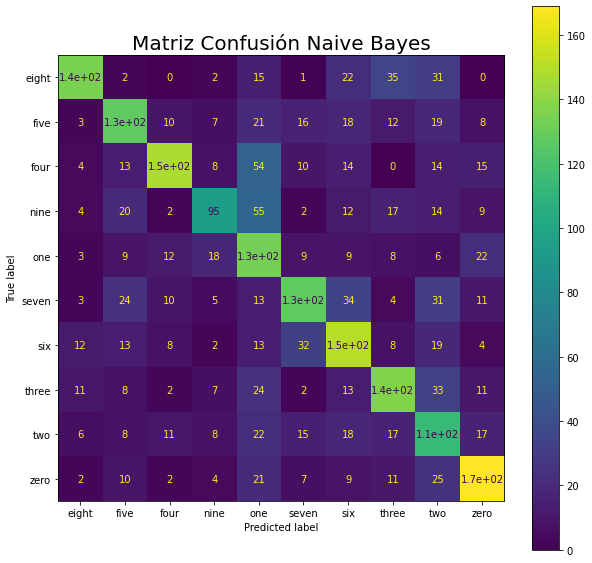

Accuracy Training : 0.541
Accuracy Test: 0.537


In [ ]:
clf_nb_ = GaussianNB()
clf_nb_.fit(x_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_nb_, x_validation, y_validation, ax = ax)
plt.title("Matriz Confusión Naive Bayes", size=20)
plt.show()

print("Accuracy Training : {:.3f}".format(clf_nb_.score(x_train, y_train)))
print("Accuracy Test: {:.3f}".format(clf_nb_.score(x_validation, y_validation)))

### Random Forest

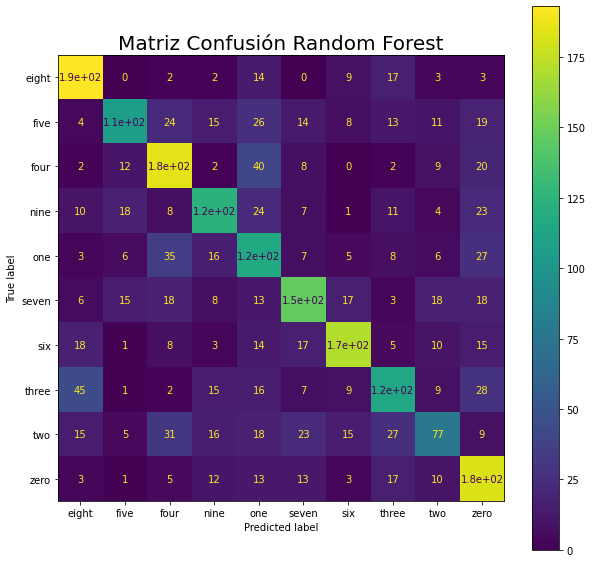

Accuracy training : 0.605
Accuracy Validation: 0.570
Best Random Forest Score 0.568 with params {'bootstrap': True, 'max_depth': 5, 'max_features': 6, 'n_estimators': 100}


In [ ]:
parameters = {'n_estimators':range(100, 200, 500), 'max_depth':range(5,10,15), 'bootstrap':[True, False], 'max_features': [6, 8, 10]}
clf_rf_ = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, scoring='accuracy')
clf_rf_.fit(x_train, y_train)

clf_rf_be_ = clf_rf_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_rf_be_, x_validation, y_validation, ax = ax)
plt.title("Matriz Confusión Random Forest", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_rf_be_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_rf_be_.score(x_validation, y_validation)))
print("Best Random Forest Score {0:.3f} with params {1}".format(clf_rf_.best_score_, clf_rf_.best_params_))

### Gradient Boosting 

1.   Initial Model (weak estimator)
2.   New Model fits to residuals
3.   New additive model
4.   Repeat n times or until error is small enough
5.   Final additive model

A diferencia de los modelos por Votación, en Gradient Boosting los estimadores no se combinan mediante votación o promedios, sino por suma. Se debe a que el primer modelo se ajusta a la variable objetivo y el resto son estimaciones de los errores residuales.

Parámetros:
*   n_estimators
*   learning_rate
*   max_depth
*   min_samples_split
*   min_samples_leaf
*   max_features

En Gradient Boosting se recomiendan utilizar todos los parámetros.

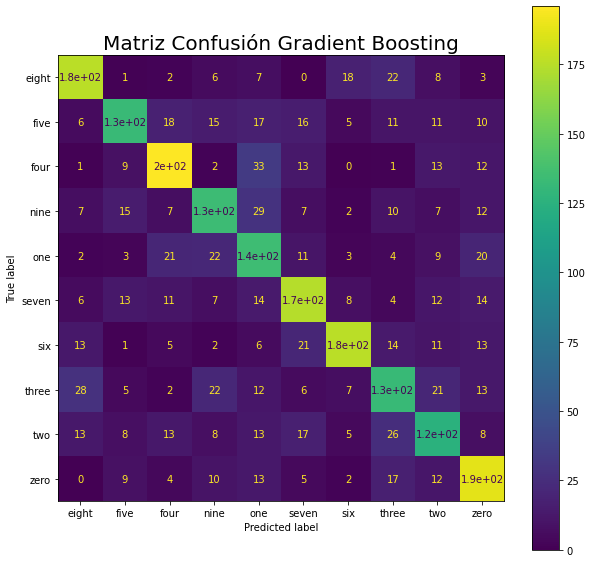

Accuracy training : 0.887
Accuracy Validation: 0.629
Best Gradient Boosting Score 0.642 with params {'learning_rate': 0.01, 'max_depth': 8, 'max_features': 10, 'n_estimators': 10}


In [ ]:
"""
parameters = {'n_estimators':range(100, 200), 'learning_rate': np.linspace(0 ,0.1), 'max_features': [6, 8, 10], 
              'n_iter_no_change': [5], 'tol': [0.01]} 

parameters = {'n_estimators':range(100, 200), 
              'learning_rate': [0 ,0.1], 
              'n_iter_no_change': [5], 'tol': [0.01]}    
"""
     
parameters = {
    "learning_rate": [0, 0.01],
    "max_depth": [3,5,8],
    'max_features': [6, 8, 10],
    "n_estimators": [10]
    }          
clf_gb_ = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy')
clf_gb_.fit(x_train, y_train)

clf_gb_be_ = clf_gb_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_gb_, x_validation, y_validation, ax = ax)
plt.title("Matriz Confusión Gradient Boosting", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_gb_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_gb_.score(x_validation, y_validation)))
print("Best Gradient Boosting Score {0:.3f} with params {1}".format(clf_gb_.best_score_, clf_gb_.best_params_))

### Multilayer Perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


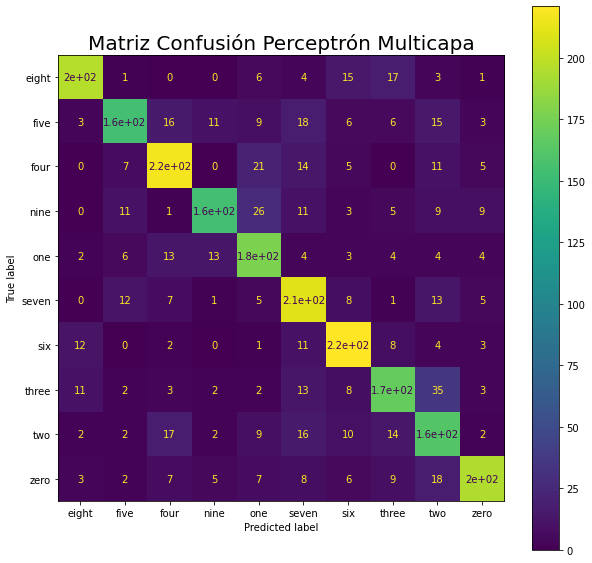

Accuracy training : 0.815
Accuracy Validation: 0.745
Best Multilayer Perceptron Score 0.764 with params {'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

clf_mlp_ = GridSearchCV(MLPClassifier(max_iter=100), parameter_space, n_jobs=-1, scoring='accuracy')
clf_mlp_.fit(x_train, y_train)

clf_mlp_be_ = clf_mlp_.best_estimator_

# En el TP se menciona lo siguiente:
# Elegir el numero de neuronas de la capa utilizando Random Search
# por lo tanto, deberíamos hacer uso de RandomizedSearchCV()? Yo venía haciendo uso de GridSearch()
#
# Qué opinan?

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_mlp_, x_validation, y_validation, ax = ax)
plt.title("Matriz Confusión Perceptrón Multicapa", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_mlp_.score(x_train, y_train)))
print("Accuracy Validation: {:.3f}".format(clf_mlp_.score(x_validation, y_validation)))
print("Best Multilayer Perceptron Score {0:.3f} with params {1}".format(clf_mlp_.best_score_, clf_mlp_.best_params_))

# Comparación performance

Text(0.5, 1.0, 'Comparación Modelos: Train&Validation Performance')

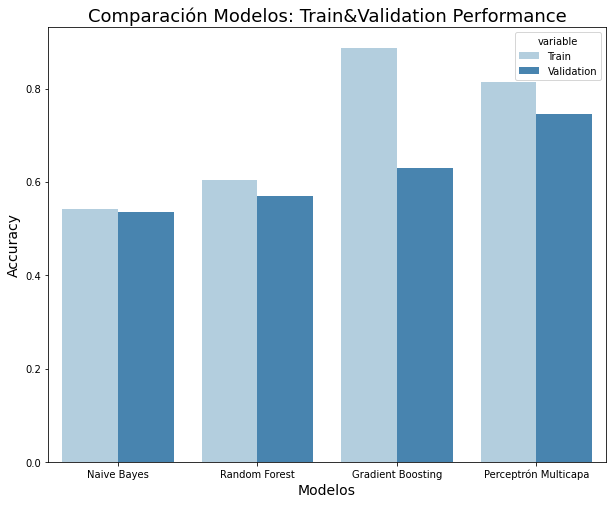

In [ ]:
dict_performance_ = {'Modelo': ['Naive Bayes', 'Random Forest', 'Gradient Boosting', 'Perceptrón Multicapa'], 
     'Train': [clf_nb_.score(x_train, y_train), 
               clf_rf_be_.score(x_train, y_train),
               clf_gb_.score(x_train, y_train),
               clf_mlp_.score(x_train, y_train)
               ], 
     'Validation':  [clf_nb_.score(x_validation, y_validation),
               clf_rf_be_.score(x_validation, y_validation),
               clf_gb_.score(x_validation, y_validation),
               clf_mlp_.score(x_validation, y_validation)
               ]}
df_performance_ = pd.DataFrame(data=dict_performance_)

plt.figure(figsize=(10, 8))
sns.barplot(x="Modelo", y="value", hue="variable", data=pd.melt(df_performance_, id_vars=['Modelo']), palette="Blues")
plt.ylabel("Accuracy", size=14)
plt.xlabel("Modelos", size=14)
plt.title("Comparación Modelos: Train&Validation Performance", size=18)

# Evaluación de Ruido

Comienzo por Instalar .rar para descomprimir los archivos de Test

In [2]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (515 kB/s)
Selecting previously unselected package rar.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
#!mkdir validation
!unrar x "/content/Testing.rar" "/content/testing/" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Testing.rar

Creating    /content/testing                                          OK
Creating    /content/testing/Testing                                  OK
Creating    /content/testing/Testing/eight                            OK
Extracting  /content/testing/Testing/eight/096456f9_nohash_0.wav           0%  OK 
Extracting  /content/testing/Testing/eight/0c40e715_nohash_0.wav           0%  OK 
Extracting  /content/testing/Testing/eight/0ea0e2f4_nohash_0.wav           0%  OK 
Extracting  /content/testing/Testing/eight/0ea0e2f4_nohash_1.wav           0%  OK 
Extracting  /content/testing/Testing/eight/1093c8e7_nohash_0.wav           0%  OK 
Extracting  /content/testing/Testing/eight/1093c8e7_nohash_1.wav           0%  OK 
Extracting  /content/testing/Testing/eight/135c6841_nohash_0.wav           0%  OK 
Extracting  /content/testing/T

Pruebas para sumar Ruido

In [10]:
#######################################################################################################
# from https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
#######################################################################################################
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real
    

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)
#######################################################################################################
#######################################################################################################
#######################################################################################################

In [4]:
# Selecciono un audio de los de Test Original
audio_numero = "/content/testing/Testing/eight/096456f9_nohash_0.wav"
x, fs = librosa.core.load(audio_numero, sr=None)
Audio(x, rate=fs)

In [6]:
# Genero Ruido
t = np.linspace(0,1,44100)
audio = np.sin(1200*t)

ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

Audio(senal, rate=44100)

In [7]:
# Otra prueba para hacerlo del mismo sr que los audios de nuestros Set's
t = np.linspace(0,1,16000)
audio = np.sin(1200*t)

ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

Audio(senal, rate=16000)

In [8]:
# A lo bruto...
audio_con_ruido = audio + x

#audio_con_ruido = x[5000:5000+len(senal)]
#result = x + senal
#Audio(x + audio)
#Audio(audio_con_ruido, rate=16000)
#Audio(audio_con_ruido)

Audio(audio_con_ruido, rate=44100)

In [11]:
# Generación de Ruido
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(x), samplerate=fs)*10
noise_clip = noise[:fs*noise_len]
audio_con_ruido = x+noise

Audio(data=audio_con_ruido, rate=fs)

In [12]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names

# Lista de Audios de Validación
zero_wavs = glob.glob('/content/testing/Testing/zero/*.wav')
one_wavs = glob.glob('/content/testing/Testing/one/*.wav')
two_wavs = glob.glob('/content/testing/Testing/two/*.wav')
three_wavs = glob.glob('/content/testing/Testing/three/*.wav')
four_wavs = glob.glob('/content/testing/Testing/four/*.wav')
five_wavs = glob.glob('/content/testing/Testing/five/*.wav')
six_wavs = glob.glob('/content/testing/Testing/six/*.wav')
seven_wavs = glob.glob('/content/testing/Testing/seven/*.wav')
eight_wavs = glob.glob('/content/testing/Testing/eight/*.wav')
nine_wavs = glob.glob('/content/testing/Testing/nine/*.wav')

vec_num = [['zero',zero_wavs],
          ['one',one_wavs],
          ['two',two_wavs], 
          ['three',three_wavs],
          ['four',four_wavs],
          ['five', five_wavs], 
          ['six', six_wavs],
          ['seven',seven_wavs],
          ['eight',eight_wavs],
          ['nine',nine_wavs]]

## Función para Ruido en Test

No lo pasé a función todavía, pero cuando tengamos la de ambientes, podemos mezclar todo en una. Por ahora, va como ejecución directa... 

In [13]:
# Voy a arrancar por generar una carpeta donde guardar el set de validación nuevo
!rm -rf '/content/testing/testing_gaussian_noise/'
os.mkdir('/content/testing/testing_gaussian_noise/')

# Y dentro, para mantener la misma estructura y saber a que Clase pertenece, genero las carpetas del subdir()
for numero in vec_num:
  os.mkdir('/content/testing/testing_gaussian_noise/'+numero[0])

In [14]:
for numero in vec_num:
  n_to_noise_ = math.floor(0.2*len(numero[1])) # obtengo la cantidad de audios a los que le voy a agregar ruido
  print("Agrego ruido a {0} elementos de la Clase {1}".format(n_to_noise_, numero[0]))
  random.shuffle(numero[1]) # mezclo los audios dentro de la lista

  j = 0 # bandera para la cantidad de audios a los que agregar ruido
  for i in range(len(numero[1])): # voy a recorrer los audios
    if j <= n_to_noise_:

      ###
      # Generacion de Ruido
      audio_numero = numero[1][i]
      x, fs = librosa.core.load(audio_numero, sr=None)
      noise_len = 2 # seconds
      noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(x), samplerate=fs)*10
      noise_clip = noise[:fs*noise_len]
      audio_con_ruido = x+noise
      ###

      nombre_audio_ = audio_numero.split('/')[4]+"/"+audio_numero.split('/')[5] # extraigo el nombre original del file + clase correspondiente
      # Voy a guardar entonces en cada carpeta los audios
      scipy.io.wavfile.write("/content/testing/testing_gaussian_noise/"+nombre_audio_, fs, audio_con_ruido)
      j+=1
    else:
      # cuando no armo ruido, copio los audios originales directamente
      copyfile(numero[1][i], "/content/testing/testing_gaussian_noise/"+numero[1][i].split('/')[4]+"/"+numero[1][i].split('/')[5])

Agrego ruido a 50 elementos de la Clase zero
Agrego ruido a 49 elementos de la Clase one
Agrego ruido a 52 elementos de la Clase two
Agrego ruido a 53 elementos de la Clase three
Agrego ruido a 50 elementos de la Clase four
Agrego ruido a 54 elementos de la Clase five
Agrego ruido a 48 elementos de la Clase six
Agrego ruido a 47 elementos de la Clase seven
Agrego ruido a 51 elementos de la Clase eight
Agrego ruido a 51 elementos de la Clase nine


In [15]:
# Finalmente Zippeo toda la carpeta que contiene los audios de Testing con el %ruido agregado.
!zip -r "/content/testing/testing_gaussian_noise.zip" "/content/testing/testing_gaussian_noise"

# Y descargo..
from google.colab import files
files.download("/content/testing/testing_gaussian_noise.zip")

  adding: content/testing/testing_gaussian_noise/ (stored 0%)
  adding: content/testing/testing_gaussian_noise/four/ (stored 0%)
  adding: content/testing/testing_gaussian_noise/four/563aa4e6_nohash_0.wav (deflated 35%)
  adding: content/testing/testing_gaussian_noise/four/af130f12_nohash_0.wav (deflated 18%)
  adding: content/testing/testing_gaussian_noise/four/863880b7_nohash_0.wav (deflated 28%)
  adding: content/testing/testing_gaussian_noise/four/37fc5d97_nohash_0.wav (deflated 26%)
  adding: content/testing/testing_gaussian_noise/four/964e8cfd_nohash_3.wav (deflated 22%)
  adding: content/testing/testing_gaussian_noise/four/91223b83_nohash_0.wav (deflated 60%)
  adding: content/testing/testing_gaussian_noise/four/b83c1acf_nohash_3.wav (deflated 21%)
  adding: content/testing/testing_gaussian_noise/four/80c45ed6_nohash_0.wav (deflated 4%)
  adding: content/testing/testing_gaussian_noise/four/b49caed3_nohash_4.wav (deflated 4%)
  adding: content/testing/testing_gaussian_noise/four/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comienzo por probar los mejores modelos con performance en Validation para que corran en Test sin y con ruido respectivamente...

In [ ]:
modelos = [('Naive Bayes', 0), ('Random Forest', 0), ('Gradient Boosting', 0), ('Multilayer Perceptron', 0)]
acc_test = {} # Voy a armar un diccionario
for modelo in modelos:
  for noise in noise_levels_:
    print(modelo, noise)

...

## Matriz de Confusión para Ruidos

In [ ]:
# Voy a hacer uso de una Matriz de Confusión "interactiva"
! pip -q install pygal

     |████████████████████████████████| 133kB 2.8MB/s 


In [ ]:
import pygal
from IPython.display import display, HTML
from pygal.style import RedBlueStyle

Si bien es para ver las matrices de confusión cuando hagamos ruido, por ahora pruebo sobre lo realizado, solo para que vean si les parece incorporarlo. Aunque no logro hacer andar el tooltip acá en Colab.

In [ ]:
render_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = render_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

    
def plot_cm(y_true, y_pred):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    dot_chart = pygal.Dot(interpolate='cubic', style=RedBlueStyle)
    dot_chart.force_uri_protocol = 'http'
    dot_chart.title = 'Matriz de Confusión'
    dot_chart.x_labels = labels
    dot_chart.x_title = "Predicho"
    dot_chart.y_title = "Real"
    for i in range(len(labels)):
        dot_chart.add(labels[i], cm[i,:])
    galplot(dot_chart)
    
plot_cm(y_validation, clf_mlp_be_.predict(x_validation))